# This script implements a simple baseline-CNN model for the Music Genre Classification task.

In [3]:
!pip install --upgrade tensorflow
!pip install --upgrade keras 

     |████████████████████████████████| 86.3MB 67kB/s 
     |████████████████████████████████| 3.8MB 43.7MB/s 
     |████████████████████████████████| 450kB 42.8MB/s 
     |████████████████████████████████| 81kB 12.0MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstall

     |████████████████████████████████| 378kB 2.8MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [0]:
# System/zip-handling imports
import os, sys
import zipfile

# Imports tensorflow
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers

# Imports image handling
import cv2
import numpy as np
import skimage

# For generating training and test data
import random

# Save training progress
import csv
from datetime import datetime
from shutil import copyfile  # Making copy of this file instance (including param settings used)


# Get sorted list of training file names:

In [5]:
# Get access to zip-archive
archive = zipfile.ZipFile('/spectrograms.zip', 'r')
imgdata = archive.read('spectrograms/spectrogram_0000.png')

files = sorted([f for f in archive.namelist()[1:] if f.startswith('spectrograms/') and f.endswith('.png')])

print(files)

['spectrograms/spectrogram_0000.png', 'spectrograms/spectrogram_0001.png', 'spectrograms/spectrogram_0002.png', 'spectrograms/spectrogram_0003.png', 'spectrograms/spectrogram_0004.png', 'spectrograms/spectrogram_0005.png', 'spectrograms/spectrogram_0006.png', 'spectrograms/spectrogram_0007.png', 'spectrograms/spectrogram_0008.png', 'spectrograms/spectrogram_0009.png', 'spectrograms/spectrogram_0010.png', 'spectrograms/spectrogram_0011.png', 'spectrograms/spectrogram_0012.png', 'spectrograms/spectrogram_0013.png', 'spectrograms/spectrogram_0014.png', 'spectrograms/spectrogram_0015.png', 'spectrograms/spectrogram_0016.png', 'spectrograms/spectrogram_0017.png', 'spectrograms/spectrogram_0018.png', 'spectrograms/spectrogram_0019.png', 'spectrograms/spectrogram_0020.png', 'spectrograms/spectrogram_0021.png', 'spectrograms/spectrogram_0022.png', 'spectrograms/spectrogram_0023.png', 'spectrograms/spectrogram_0024.png', 'spectrograms/spectrogram_0025.png', 'spectrograms/spectrogram_0026.png', 

# JFF: Get a feeling for the nature of the training and evaluation data:

Type of image:
<class 'numpy.ndarray'>
Dimension of a single image file:
(512, 512, 3)


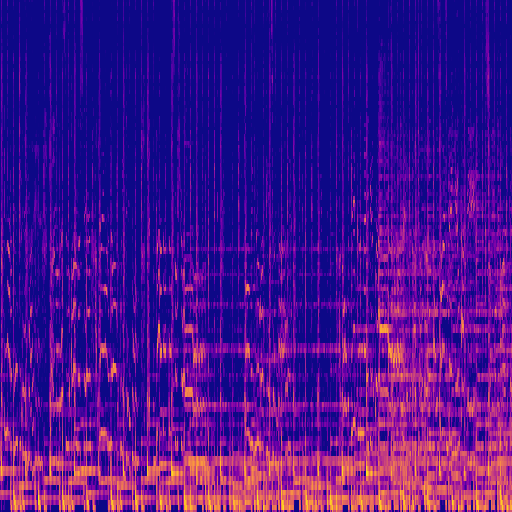

In [9]:
# Interpret image-data as image
from google.colab.patches import cv2_imshow
image = cv2.imdecode(np.frombuffer(imgdata, dtype=np.uint8), 1)

# Print some specs...
print('Type of image:')
print(type(image))
print('Dimension of a single image file:')
print(image.shape)
img_height, img_width, img_channels = image.shape
# Show image visually (press any key in opening window in order to proceed in code...)
cv2_imshow( image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Read in both training and testing data from zip archive:

In [10]:
data_set = []
# Data storage
combined_data = np.empty([1, img_height, img_width])

# Read in images & store processed instances
for f_name in files:
    # Get image data from zip file
    zip_img_data = archive.read(f_name)
    image = cv2.imdecode(np.frombuffer(zip_img_data, dtype=np.uint8), 1)
    
    # Normalize image's colors to range [0, 1]
    image = image / 255.0

    #cv2.imshow("Normalized Image", image)
    #cv2.waitKey(0)

    # Grayscale image
    gray_image = skimage.color.rgb2gray(image)

    #cv2.imshow("Grayscale Image", gray_image)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

    # Store grayscaled image
    combined_data = np.append(combined_data, [gray_image], axis=0)
    
# Remove initial, empty datapoint
combined_data = combined_data[1:, :, :]

print('Done reading in... Shape of data array:')
print(combined_data.shape)
print('Done.')

Done reading in... Shape of data array:
(1000, 512, 512)
Done.


# Read in labels:

In [11]:
labels_path = '/labels.txt'

combined_labels = np.empty([1])

with open(labels_path, 'r') as file:
    for line in file:
        combined_labels = np.append(combined_labels, [int(line)])

# Remove initial, empty datapoint
combined_labels = combined_labels[1:] 
print(combined_labels)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.

# Divide data into train and test data:

------------------------------------------------------
Training data will be contained in:    training_data
Tetsing  data will be contained in:    testing_data

Training labels will be contained in:  training_labels
Tetsing  labels will be contained in:  testing_labels

In [12]:
# Get set of test-indices which indicates the training data points that have to be reserved for training
percentage_test_data = 0.2
population = range(len(combined_labels))
nr_samples = int(percentage_test_data * len(combined_labels))

test_indices = random.sample(population, nr_samples)
test_indices = sorted(test_indices)

print('Nr. test indices: ' + str(len(test_indices)))
print('Test indices: ' + str(test_indices))


# Split data into training- and test data, respectively - Preparation: Create empty arrays in which to later insert data
test_len = len(test_indices)
train_len = len(combined_labels)-len(test_indices)
training_data, training_labels = np.empty([train_len, img_height, img_width]), np.empty([train_len])
testing_data, testing_labels = np.empty([test_len, img_height, img_width]), np.empty([test_len])

test_idx_list_idx = 0
i = 0

# Iterate through all data and assign each data point either to training data or testing data
for data_idx in range(len(combined_labels)):

    if test_idx_list_idx < nr_samples and data_idx == test_indices[test_idx_list_idx]:
        testing_data[test_idx_list_idx, :, :] = combined_data[data_idx, :, :]
        testing_labels[test_idx_list_idx] = combined_labels[data_idx]
        test_idx_list_idx += 1
        
    else:
        
        training_data[i, :, :] = combined_data[data_idx, :, :]
        training_labels[i] = combined_labels[data_idx]
        i += 1
        

training_data = training_data.reshape([len(training_labels), img_height, img_width, 1])

testing_data = testing_data.reshape([len(testing_labels), img_height, img_width, 1])
        
print('Final:')
print(training_data.shape)
print(training_labels.shape)
print(testing_data.shape)
print(testing_labels.shape)


Nr. test indices: 200
Test indices: [2, 8, 13, 16, 31, 41, 46, 55, 57, 61, 63, 74, 78, 85, 86, 88, 93, 96, 97, 98, 99, 100, 113, 117, 119, 128, 135, 136, 137, 143, 152, 158, 160, 172, 179, 181, 184, 186, 187, 202, 214, 218, 221, 223, 227, 234, 241, 244, 246, 247, 256, 259, 266, 268, 271, 281, 287, 290, 293, 296, 297, 299, 301, 303, 305, 309, 319, 327, 328, 330, 331, 332, 338, 339, 349, 352, 353, 357, 358, 359, 364, 367, 388, 391, 399, 402, 420, 421, 426, 428, 439, 444, 447, 452, 455, 457, 458, 459, 477, 479, 493, 498, 499, 509, 515, 522, 524, 528, 533, 536, 557, 558, 571, 572, 577, 585, 589, 590, 595, 604, 605, 611, 612, 617, 622, 626, 628, 629, 630, 632, 638, 643, 651, 652, 659, 681, 688, 693, 696, 698, 711, 721, 727, 744, 748, 749, 752, 753, 760, 761, 771, 772, 773, 776, 787, 791, 803, 808, 814, 816, 818, 823, 826, 829, 831, 833, 834, 837, 847, 857, 866, 873, 877, 880, 884, 899, 901, 905, 921, 922, 923, 924, 925, 927, 928, 930, 932, 934, 935, 941, 946, 951, 952, 963, 966, 974, 977, 9

# Set up the CNN architecture:

In [15]:
# Reset tf sessions
tf.keras.backend.clear_session()  # Destroys the current TF graph and creates a new one.

dimensions = 512
classes = 10

# Set up model architecture in terms of its layers
model = models.Sequential()

model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(dimensions, dimensions, 1),
                                                       kernel_regularizer=regularizers.l2(0.01)))

model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.01)))

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(512, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))


model.add(layers.Flatten())

model.add(layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.05)))

model.add(layers.Dropout(0.3))

model.add(layers.Dense(classes, activation='softmax'))

# Note on regularizer(s), copied from https://www.tensorflow.org/tutorials/keras/overfit_and_underfit:
# l2(0.001) means that every coefficient in the weight matrix of the layer will add 0.001 * weight_coefficient_value**2
# to the total loss of the network.

# Print summary
model.summary()

# Compile model & make some design choices
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001, #0.001
                                           beta_1=0.9,
                                           beta_2=0.999,
                                           epsilon=1e-07,
                                           amsgrad=False,
                                           name='Adam'
                                           ),
              loss='sparse_categorical_crossentropy',  # Capable of working with regularization
              metrics=['accuracy', 'sparse_categorical_crossentropy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 508, 508, 32)      832       
_________________________________________________________________
dropout (Dropout)            (None, 508, 508, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 254, 254, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 250, 250, 64)      51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 125, 125, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 125, 125, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 123, 123, 128)     7

# Execute training:

Start training process:
    Run X times Y tensorflow-epochs and save a model as checkpoint after any Y epochs. 
    FIXME: Bit hacky solution, yet, but can be prettyfied.
    
IMPORTANT: 'accuracy'     == accuracy achieved during training on training data;  * the UN-important measure
           'val_accuracy' == accuracy achieved on TEST data AFTER training epoch; * the important measure

In [0]:
# Set up folder for data gathering during training process
now = datetime.now()
TIME_STAMP = now.strftime("_%Y_%d_%m__%H_%M_%S__%f")
MODEL_ID = 'Model_' + TIME_STAMP + '/'
path = 'TrainingRun/' + MODEL_ID

if not os.path.exists(path):
    os.makedirs(path)

# Set up documentation (csv doc) of training progress
with open(path+'training_progress.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["epoch", "loss", "accuracy", "val_loss", "val_accuracy", "sparse_categorical_crossentropy"])
    file.close()


# Save initial model - For preventing memory leaks


# Run training
repetitions = 10    # How many repetitions of given nr of epochs
eps = 10            # tf-Epochs
accuracy = 0
min_acc = 0.85

for i in range(repetitions):
    # Live terminal update
    print('Completed epochs so far: ' + str(i*eps))
    
    # Prevent memory leakage
    

    # Perform x epochs of training
    history = model.fit(training_data, training_labels,
                        epochs=eps,
                        validation_data=(testing_data, testing_labels))
    
    # Get string representation of performed number of training epochs & new model name
    epoch = str((i+1)*eps)
    name = 'cnn_model_'+epoch+'_acc_'+str(history.history['val_accuracy'])
    
    # Save the entire model as a checkpoint and/or final model to a HDF5 file.
    model.save(path+name+'.h5')
    
    # Record training progress
    with open(path+'training_progress.csv', 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch,
                         history.history["loss"][0], 
                         history.history["accuracy"][0], 
                         history.history["val_loss"][0], 
                         history.history["val_accuracy"][0],
                         history.history["sparse_categorical_crossentropy"][0]
                         ])
        file.close()

    if accuracy >= min_acc and history.history['val_accuracy'][0] < accuracy:
        # Drop in accuracy on evaluation data. Overfitting?
        break
    else:
        accuracy = history.history['val_accuracy'][0]
print('Done.')

Completed epochs so far: 0
Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 1040s 1s/sample - loss: 74.4133 - accuracy: 0.1063 - sparse_categorical_crossentropy: 2.3068 - val_loss: 44.3307 - val_accuracy: 0.0900 - val_sparse_categorical_crossentropy: 2.3018
Epoch 2/10
800/800 [==============================] - 1035s 1s/sample - loss: 29.0961 - accuracy: 0.1025 - sparse_categorical_crossentropy: 2.3012 - val_loss: 17.3196 - val_accuracy: 0.1050 - val_sparse_categorical_crossentropy: 2.3012
Epoch 3/10
800/800 [==============================] - 1035s 1s/sample - loss: 12.1394 - accuracy: 0.1138 - sparse_categorical_crossentropy: 2.2998 - val_loss: 8.3196 - val_accuracy: 0.1450 - val_sparse_categorical_crossentropy: 2.3009
Epoch 4/10
800/800 [==============================] - 1034s 1s/sample - loss: 6.7387 - accuracy: 0.1138 - sparse_categorical_crossentropy: 2.2966 - val_loss: 5.5772 - val_accuracy: 0.1600 - val_sparse_categorical_crossen